# LogReg with plain AutoGrad (from scratch)

_But wait, LogReg is not Deep Learning! Why should we care?_  
_Well, we use LogReg as an excuse to explore `autograd` in an iterative loop to implement gradient descent from scratch, using pytorch only for gradient computation._

### Learning Objectives
- use autograd to compute gradient for a given modeling formula (LogReg)

### Requirements

To benefit from this content, it is preferable to know:
- how Logistic Regression works (log likelyhood, etc)
- how basic gradient descent works (learning rate, etc)

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

## 1. Fake data with "hidden" truth function

In [2]:
hidden_beta = numpy.array([1.25, -1.5, 0.1])

def truth_function(x, hidden_beta):
    dotprod = hidden_beta[0] * x[0,:] + hidden_beta[1] * x[1,:] + hidden_beta[2]
    return (dotprod > 0).astype(float)

attributes = numpy.random.random((2,100))
target = truth_function(attributes, hidden_beta).astype(float)

Let's scatter plot this...

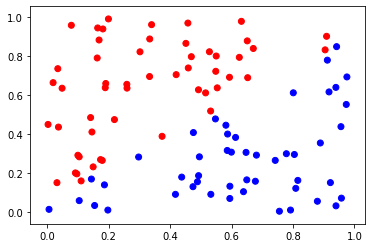

In [3]:
target_colors = ['blue' if t == 1 else 'red' for t in target]
plt.scatter(attributes[0,:], attributes[1,:], c=target_colors)

## 2. LogReg model with just plain tensors

First, data prep...

In [4]:
attributes_biasterm = numpy.vstack([
    attributes,
    numpy.ones(attributes.shape[1]) # add a bias term first
])

# those don't require grad
X = torch.tensor(attributes_biasterm, requires_grad=False).float()
Y = torch.tensor(target, requires_grad=False).float()

In [5]:
# this is our parameter tensor, it requires grad
beta_t = torch.rand((1, 3), requires_grad=True)

with torch.no_grad():
    beta_t /= torch.norm(beta_t)

Let's just see what predictions this random $\beta$ will give (probably bad).

We'll apply the basic LogReg formula:

$$P(y|x) = \frac{1}{1 + e^{-\beta^T.x}}$$

In [6]:
with torch.no_grad():
    # prediction from LogReg
    P_y_given_x = 1 / (1 + torch.exp(-torch.mm(beta_t,X)))
    Y_hat = (P_y_given_x > 0.5).float()
    errors = torch.sum(torch.abs(Y_hat - Y)).item()
    print("Accuracy: {:2f}%".format(100 * ( 1 - errors / Y.shape[0])))

Accuracy: 48.000000%


# Training

In [7]:
beta_memory = []
lambda_reg = 0.1
learning_rate = 0.01
steps = 10000

for step in range(steps):
    LogL = torch.sum(
        Y * torch.mm(beta_t,X)
        - torch.log(1 + torch.exp(torch.mm(beta_t,X)))
    )
    LogL.backward()
    
    # we update beta using gradient descent
    beta_t.requires_grad = False           # autograd needs to stop during iteration
    beta_memory.append(beta_t.numpy())     # we store beta for fun
    beta_t += learning_rate * beta_t.grad  # apply GD
    beta_t /= torch.norm(beta_t)
    beta_t.requires_grad = True            # autograd back on for next iteration
    
    if step % (steps // 20) == 0:
        print("step={}, LogL={:5f}".format(step, LogL.item()))


step=0, LogL=-88.265610
step=500, LogL=-58.094646
step=1000, LogL=-58.094646
step=1500, LogL=-58.094643
step=2000, LogL=-58.094650
step=2500, LogL=-58.094646
step=3000, LogL=-58.094650
step=3500, LogL=-58.094646
step=4000, LogL=-58.094639
step=4500, LogL=-58.094646
step=5000, LogL=-58.094643
step=5500, LogL=-58.094646
step=6000, LogL=-58.094654
step=6500, LogL=-58.094654
step=7000, LogL=-58.094650
step=7500, LogL=-58.094643
step=8000, LogL=-58.094646
step=8500, LogL=-58.094654
step=9000, LogL=-58.094654
step=9500, LogL=-58.094654


In [8]:
with torch.no_grad():
    # prediction from LogReg
    P_y_given_x = 1 / (1 + torch.exp(-torch.mm(beta_t,X)))
    Y_hat = (P_y_given_x > 0.5).float()
    errors = torch.sum(torch.abs(Y_hat - Y)).item()
    print("Accuracy: {:2f}%".format(100 * ( 1 - errors / Y.shape[0])))

Accuracy: 92.000000%


In [9]:
from scipy.spatial.distance import cosine

print(beta_memory[-1][0])
print(hidden_beta)

cosine(hidden_beta, beta_memory[-1][0])

[ 0.6293685  -0.7769946  -0.01321963]
[ 1.25 -1.5   0.1 ]


0.0021691685717722953